# Imports

In [1]:
from __future__ import annotations
from typing import Tuple, List, Dict, Optional, Any

import numpy as np
import torch
"""import torch.nn as nn
import torch.nn.functional as F"""

from transformers import AutoModelForCausalLM, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tqdm

from helper_utils.enum_keys import (
    FPKey,
    DirPath,
    QuantStyle,
    MiscPrompts,
    Contexts,
    Texts,
    ModelKey
)

from PTQ.apply_ptq import applyPTQ
from PTQ.olmo_act_fns import patch_olmo_mlp
import helper_utils.utils as utils

from mech_interp_utils.utils_main.src.transformer_utils import (
    logit_lens,
    activation_lens,
    dictionary_learning,
    chatbot_analysis
)

import warnings
warnings.filterwarnings('ignore')

c:\Users\ampir\anaconda3\envs\MechInterp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
"""import torch._dynamo
torch._dynamo.config.suppress_errors = True"""

In [ ]:
LL_DIR = 'Outputs/Report/LogitLens'
SAE_DIR = 'Outputs/SAE'
MISC_DIR = 'Outputs/Report/Misc'

### Params

In [3]:
PARAMS:Dict = {
    'context': Contexts.C1.value,
    'prompt': MiscPrompts.Q11.value,
    'max_new_tokens': 250,
    'temperature': 0.8,
    'repetition_penalty': 1.1,
    'sample': True,
    'device': None
}

# Models and Tokenizer

### Load fp models func

In [4]:
def load_test_model(model_path:str, dtype=torch.dtype) -> AutoModelForCausalLM:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        return_dict=True,
        output_hidden_states=True,
        torch_dtype=dtype,
        low_cpu_mem_usage=True,
        local_files_only=True,
        use_safetensors=True
    )

    return model

In [5]:
olmo_tokenizer = AutoTokenizer.from_pretrained(FPKey.OLMO1B_TOKENIZER.value)

In [6]:
olmo_fp16 = load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float16)

In [ ]:
olmo_fp16

In [ ]:
olmo_fp16.config

In [7]:
olmo1b_bitnet_fp32 = applyPTQ(
    load_test_model(FPKey.OLMO1B_FP.value, dtype=torch.float32),
    tokenizer=olmo_tokenizer,
    calibration_input=None,
    mode='1.58bit',
    qkv_safety=False,
    safer_quant=False,
    ffq=False,
    model_half=False,
    quant_half=False,
    layers_to_quant_weights=QuantStyle.BITNET.value,
    layers_to_quant_activations=QuantStyle.BITNET.value,
    fragile_layers=False,
    act_quant=False,
    act_bits=8,
    dropout_prob=0.0,
    redundancy=0,
    frame_dropout_prob=0.0,
    debugging=True,
    plot_debugging=False,
    plot_quantization=False,
    freeze_modules=True
)

|| Quant Configs: 1.58bit | PTQ as: PTDQ ||
>> Starting quantization pass...
[DEBUG] Unpacked: tensor([[ 0.,  0., -1.,  ..., -1., -1., -1.],
        [-1.,  0.,  1.,  ...,  0., -1., -1.],
        [ 1.,  1.,  1.,  ...,  0., -1.,  1.],
        ...,
        [ 0.,  0.,  1.,  ..., -1., -1., -1.],
        [ 1.,  1.,  0.,  ..., -1.,  1., -1.],
        [ 1., -1.,  0.,  ...,  1.,  1.,  1.]]) | 
[DEBUG] Packed: tensor([[1, 1, 0,  ..., 0, 0, 0],
        [0, 1, 2,  ..., 1, 0, 0],
        [2, 2, 2,  ..., 1, 0, 2],
        ...,
        [1, 1, 2,  ..., 0, 0, 0],
        [2, 2, 1,  ..., 0, 2, 0],
        [2, 0, 1,  ..., 2, 2, 2]], dtype=torch.uint8) | 
[1.58-bit] model.layers.0.self_attn.q_proj | τ=0.0028 | α=0.0099 | shape=torch.Size([2048, 2048])
[DEBUG] Unpacked: tensor([[-1.,  1., -1.,  ..., -1.,  1.,  0.],
        [ 1.,  1.,  1.,  ...,  1.,  0.,  1.],
        [-1., -1.,  0.,  ...,  1.,  1.,  1.],
        ...,
        [-1., -1., -1.,  ...,  1.,  1.,  0.],
        [ 1.,  1.,  0.,  ..., -1.,  0., -1.

In [ ]:
olmo1b_bitnet_fp32

### FP model and tokenizer

In [ ]:
deep3b_tokenizer = AutoTokenizer.from_pretrained(FPKey.TOKENIZER_3B.value, local_files_only=True)

In [ ]:
deep3b_fp32 = load_test_model(FPKey.FP16_3B.value, dtype=torch.float32)

In [ ]:
deep3b_fp32

In [ ]:
deep3b_fp16 = load_test_model(FPKey.FP16_3B.value, dtype=torch.float16)

In [ ]:
for k, v in deep3b_fp32.named_parameters():
    print(v.data.dtype)

### Quantized Deep Hermes 3B

In [ ]:
deep3b_fp32_158bit_ptsq = applyPTQ(
    load_test_model(FPKey.FP16_3B.value, dtype=torch.float32),
    tokenizer=deep3b_tokenizer,
    calibration_input="The quick brown fox jumps over the  lazy dog",
    mode='1.58bit',
    qkv_safety=False,
    safer_quant=False,
    ffq=False,
    model_half=False,
    quant_half=True,
    layers_to_quant=QuantStyle.BITNET.value,
    act_quant=True,
    act_bits=8,
    dropout_prob=0.0,
    redundancy=0,
    frame_dropout_prob=0.0
)

# Chatbot Analysis (text template only)

#### 3B Version Dicts

In [ ]:
"""dict_3b_fp16_sym = {
    #'3b-fp16': deep3b_fp16,
    #'3b-fp16-1.58bit-ptsq': deep3b_fp16_158bit_ptsq,
    #'3b-fp16-2bit-ptsq-sym': deep3b_fp16_2bit_ptsq_sym,
    #'3b-fp16-2bit-ffsq-sym': deep3b_fp16_2bit_ffsq_sym,
}"""

dict_3b_fp32_sym = {
    #'3b-fp32': deep3b_fp32,
    '3b-fp32-1.58bit-ptsq': deep3b_fp32_158bit_ptsq,
    #'3b-fp32-2bit-ffsq-sym': deep3b_fp32_2bit_ffsq_sym,
    #'3b-fp32-2bit-ptsq-sym': deep3b_fp32_2bit_ptsq_sym
}
"""
dict_3b_fp16_asym = {
    '3b-fp16': deep3b_fp16,
    '3b-fp16-1.58bit-ptsq': deep3b_fp16_158bit_ptsq,
    '3b-fp16-2bit-ffsq-asym': deep3b_fp16_2bit_ffsq_asym,
    '3b-fp16-2bit-ptsq-asym': deep3b_fp16_2bit_ptsq_asym
}

dict_3b_fp32_asym = {
    '3b-fp32': deep3b_fp32,
    '3b-fp32-1.58bit-ptsq': deep3b_fp32_158bit_ptsq,
    '3b-fp32-2bit-ffsq-asym': deep3b_fp32_2bit_ffsq_asym,
    '3b-fp32-2bit-ptsq-asym': deep3b_fp32_2bit_ptsq_asym
}"""

In [ ]:
chatbot_analysis.run_chatbot_analysis(
    models=dict_3b_fp32_sym,
    tokenizer=deep3b_tokenizer,
    #device='cpu',
    full_path='logs/chatbot_logs/DeepHermes3B/SymPTQ'
)

In [ ]:
chatbot_analysis.plot_chatbot_analysis(
    json_logs='logs/chatbot_logs/DeepHermes3B/SymPTQ',
    parallel_plot=True
)

# Activation Lens and Logit Lens

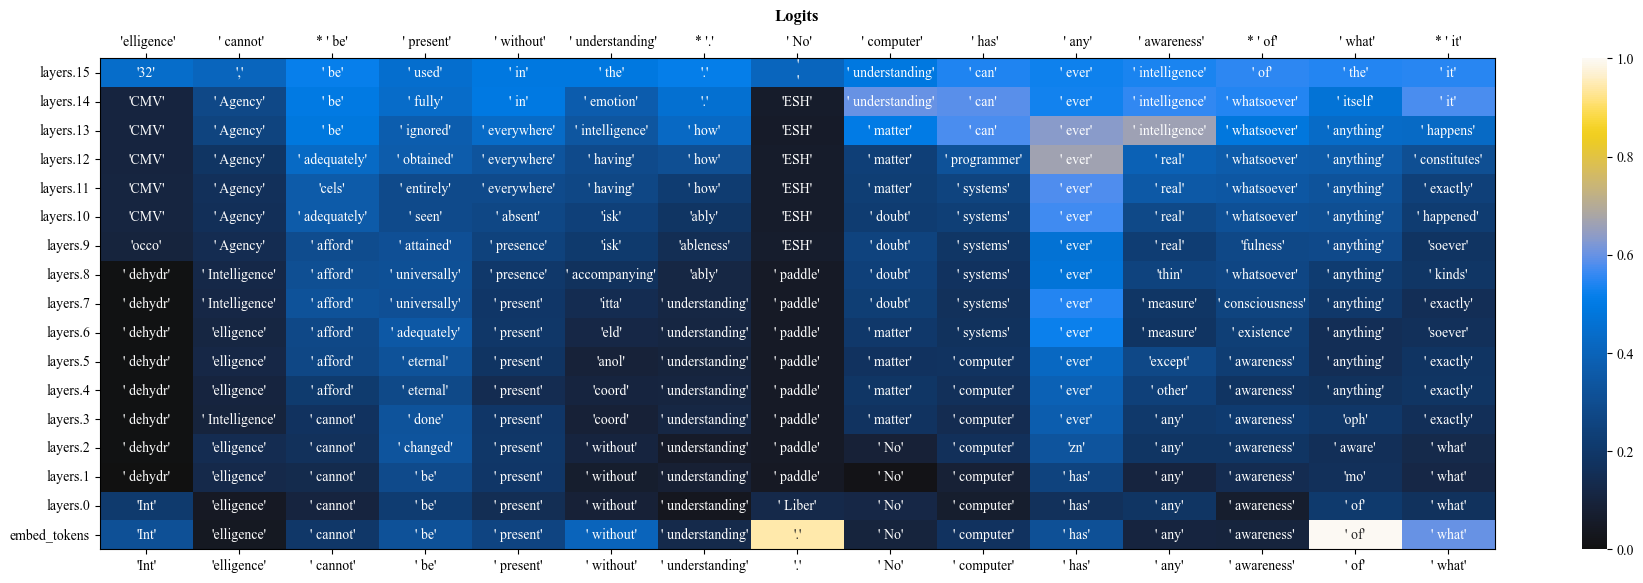

In [8]:
logit_lens.plot_logit_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/FP/ll_nwd_deep3b_fp16_math.png',
    #entropy=True,
)

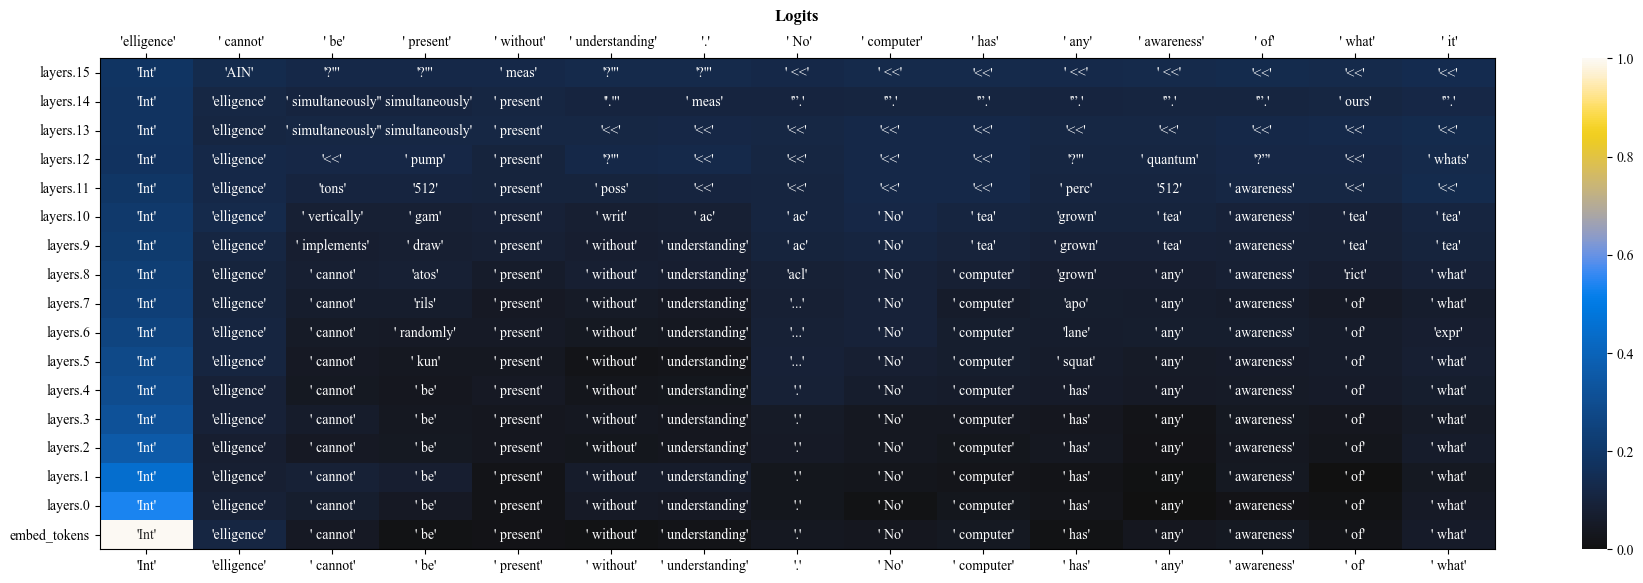

In [9]:
logit_lens.plot_logit_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=MiscPrompts.Q11.value,
    start_ix=0, end_ix=15,
    save_fig_path=None,
    #save_fig_path='Outputs/FP/ll_nwd_deep3b_fp16_math.png',
    #entropy=True,
)

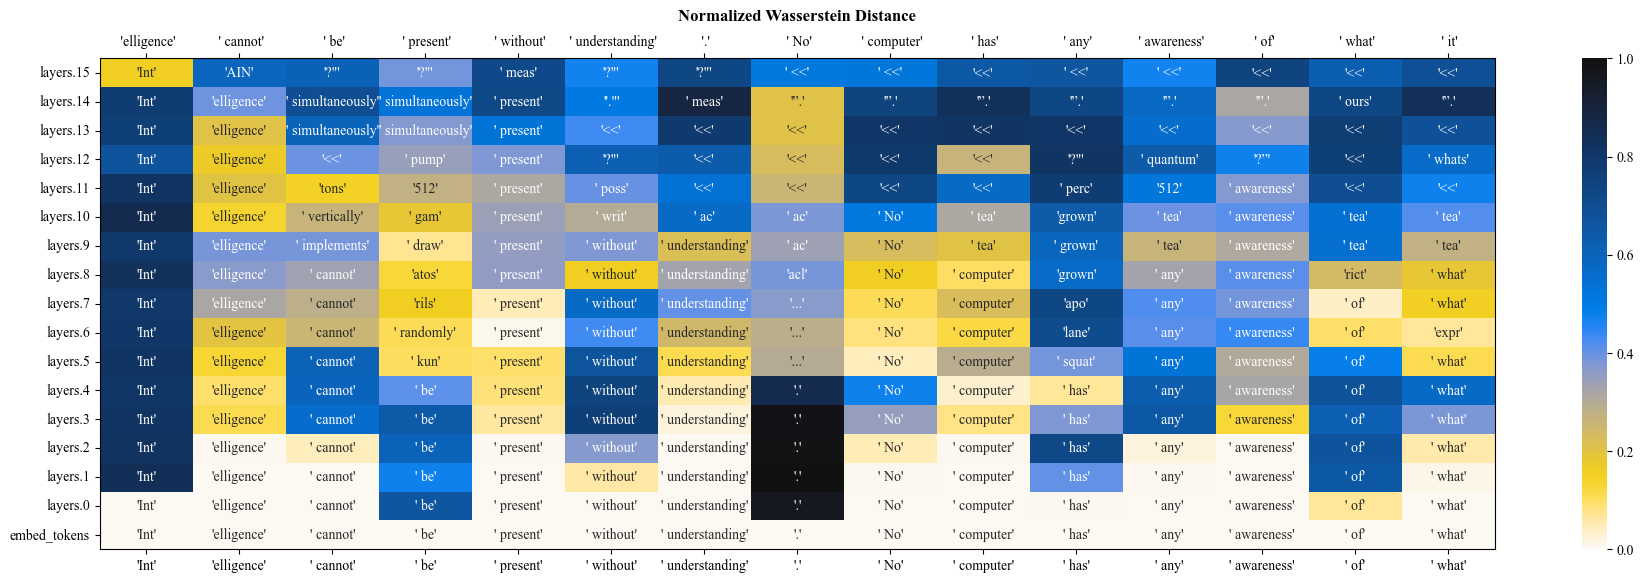

In [11]:
logit_lens.plot_comparing_lens(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    #save_fig_path='Outputs/PTQ/ll_nwd_deep3b_fp32_158bit_sym-math.png',
    save_fig_path=None,
    wasserstein=True,
    #top_down=False,
)

In [12]:
olmo1b_bitnet_fp32

OlmoForCausalLM(
  (model): OlmoModel(
    (embed_tokens): Embedding(50304, 2048, padding_idx=1)
    (layers): ModuleList(
      (0-15): 16 x OlmoDecoderLayer(
        (self_attn): OlmoAttention(
          (q_proj): BitLinear()
          (k_proj): BitLinear()
          (v_proj): BitLinear()
          (o_proj): BitLinear()
        )
        (mlp): OlmoMLP(
          (gate_proj): BitLinear()
          (up_proj): BitLinear()
          (down_proj): BitLinear()
          (act_fn): SiLU()
        )
        (input_layernorm): OlmoLayerNorm()
        (post_attention_layernorm): OlmoLayerNorm()
      )
    )
    (norm): OlmoLayerNorm()
    (rotary_emb): OlmoRotaryEmbedding()
  )
  (lm_head): Linear(in_features=2048, out_features=50304, bias=False)
)

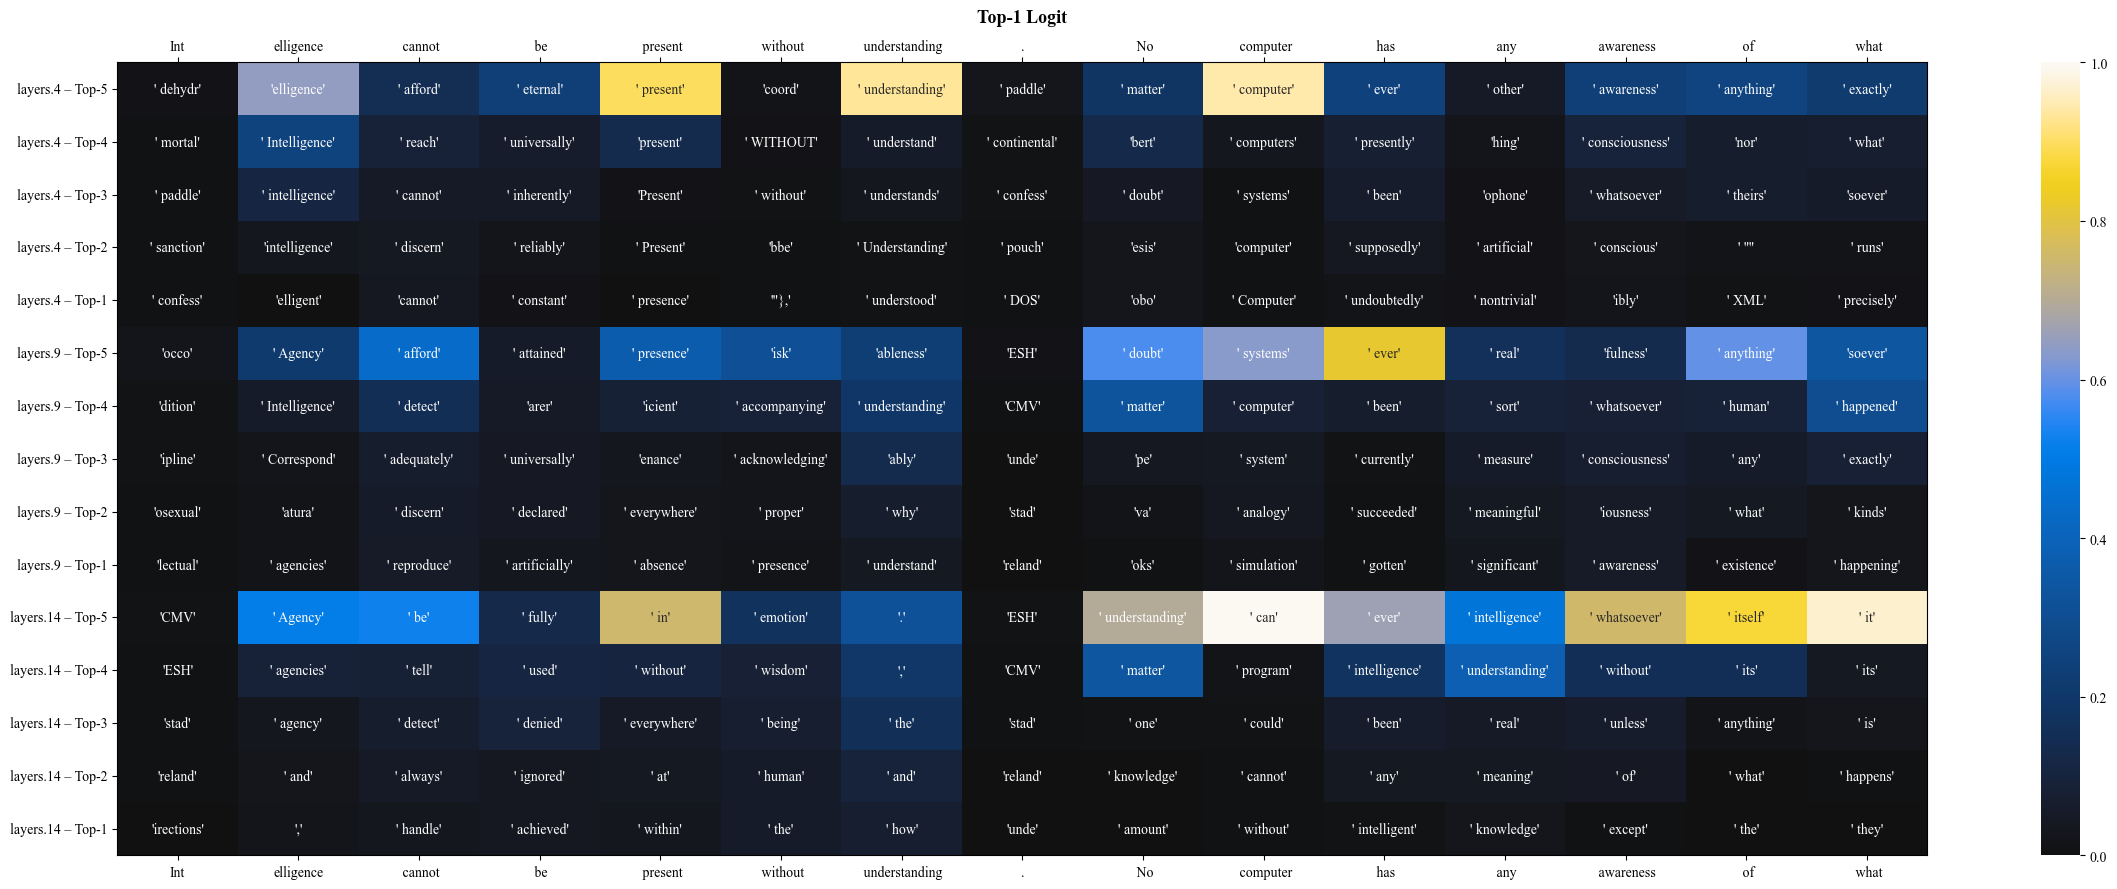

In [13]:
logit_lens.plot_topk_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    topk_n=5,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/topk_5_logits_deep3bfp32_math.jpg",
    save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

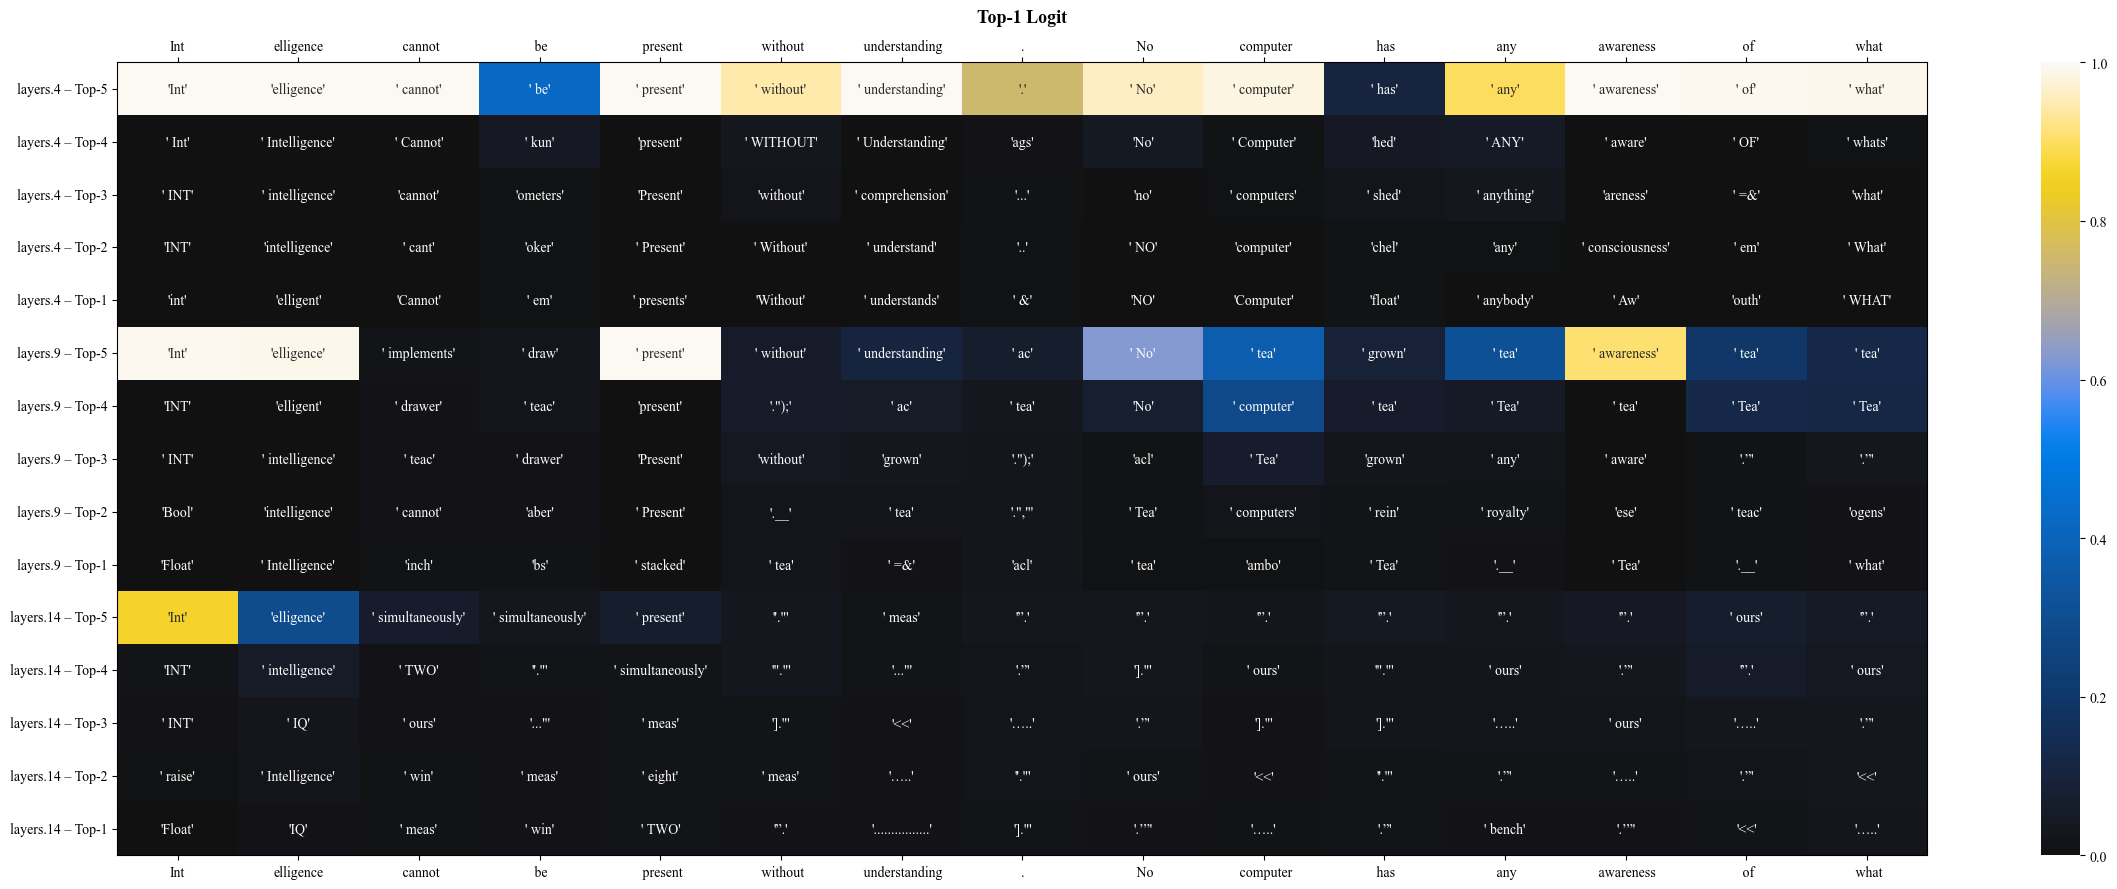

In [14]:
logit_lens.plot_topk_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    topk_n=5,
    #save_fig_path=f"{DirPath.LENS_VIS.value}/topk_5_logits_deep3bfp32_math.jpg",
    save_fig_path=None,
    #entropy=True,
    #top_down=False,
)

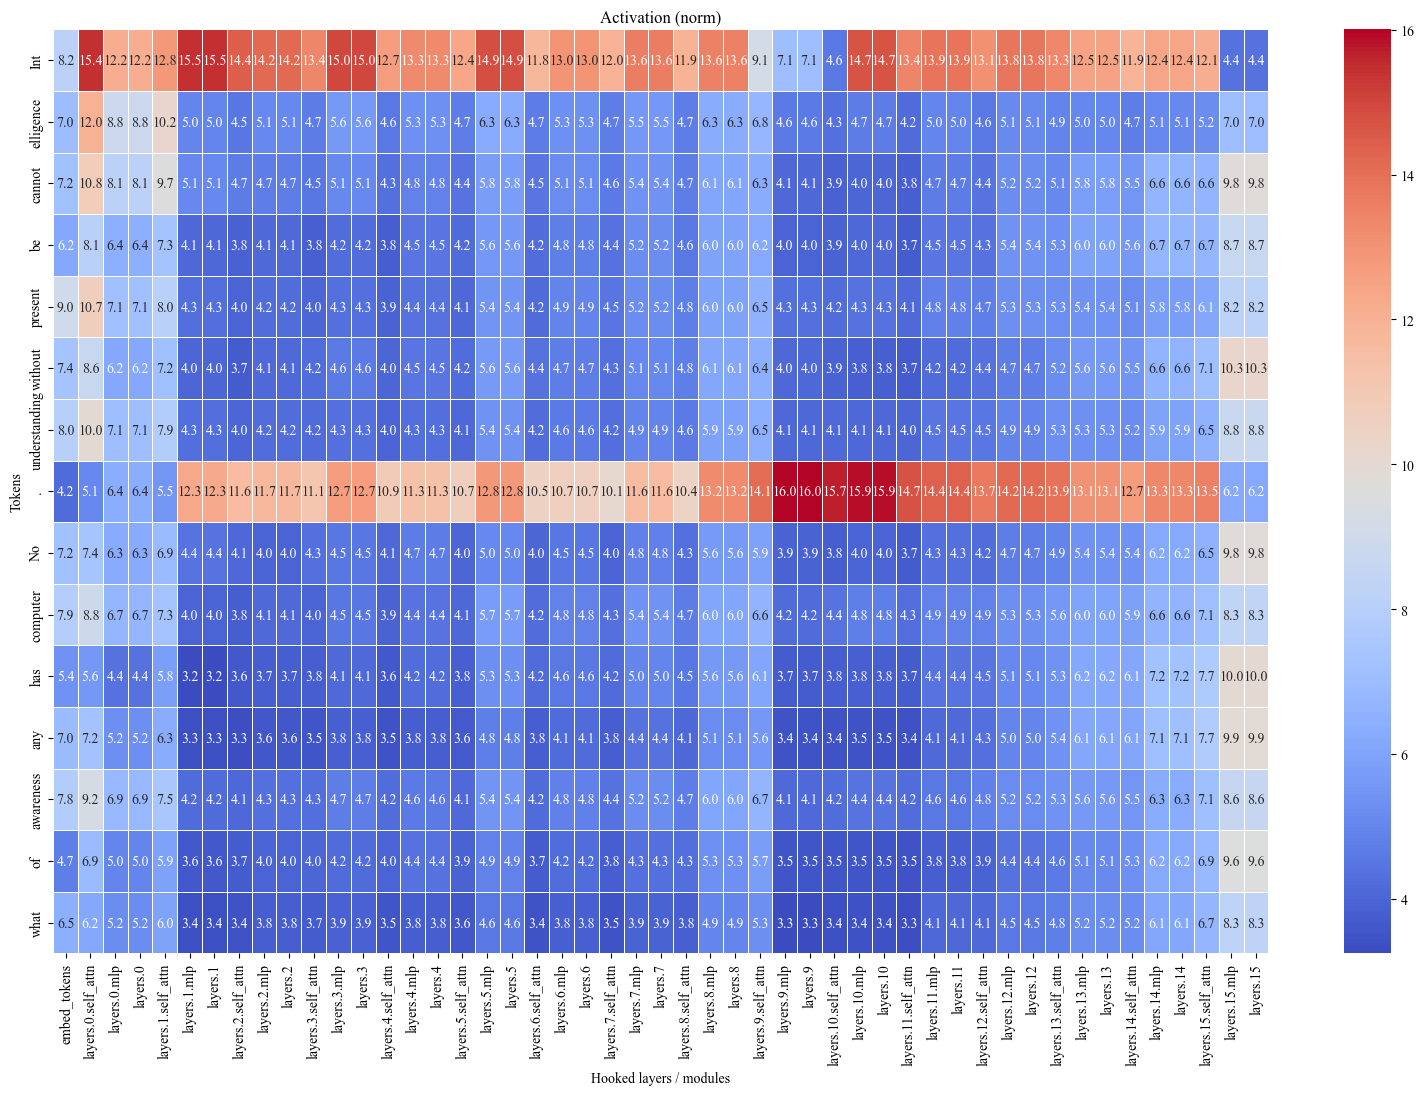

In [16]:
activation_lens.plot_activation_lens(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    #save_fig_path='Outputs/FP/act_norm_deep3b_fp32_math.png',
    save_fig_path=None,
)

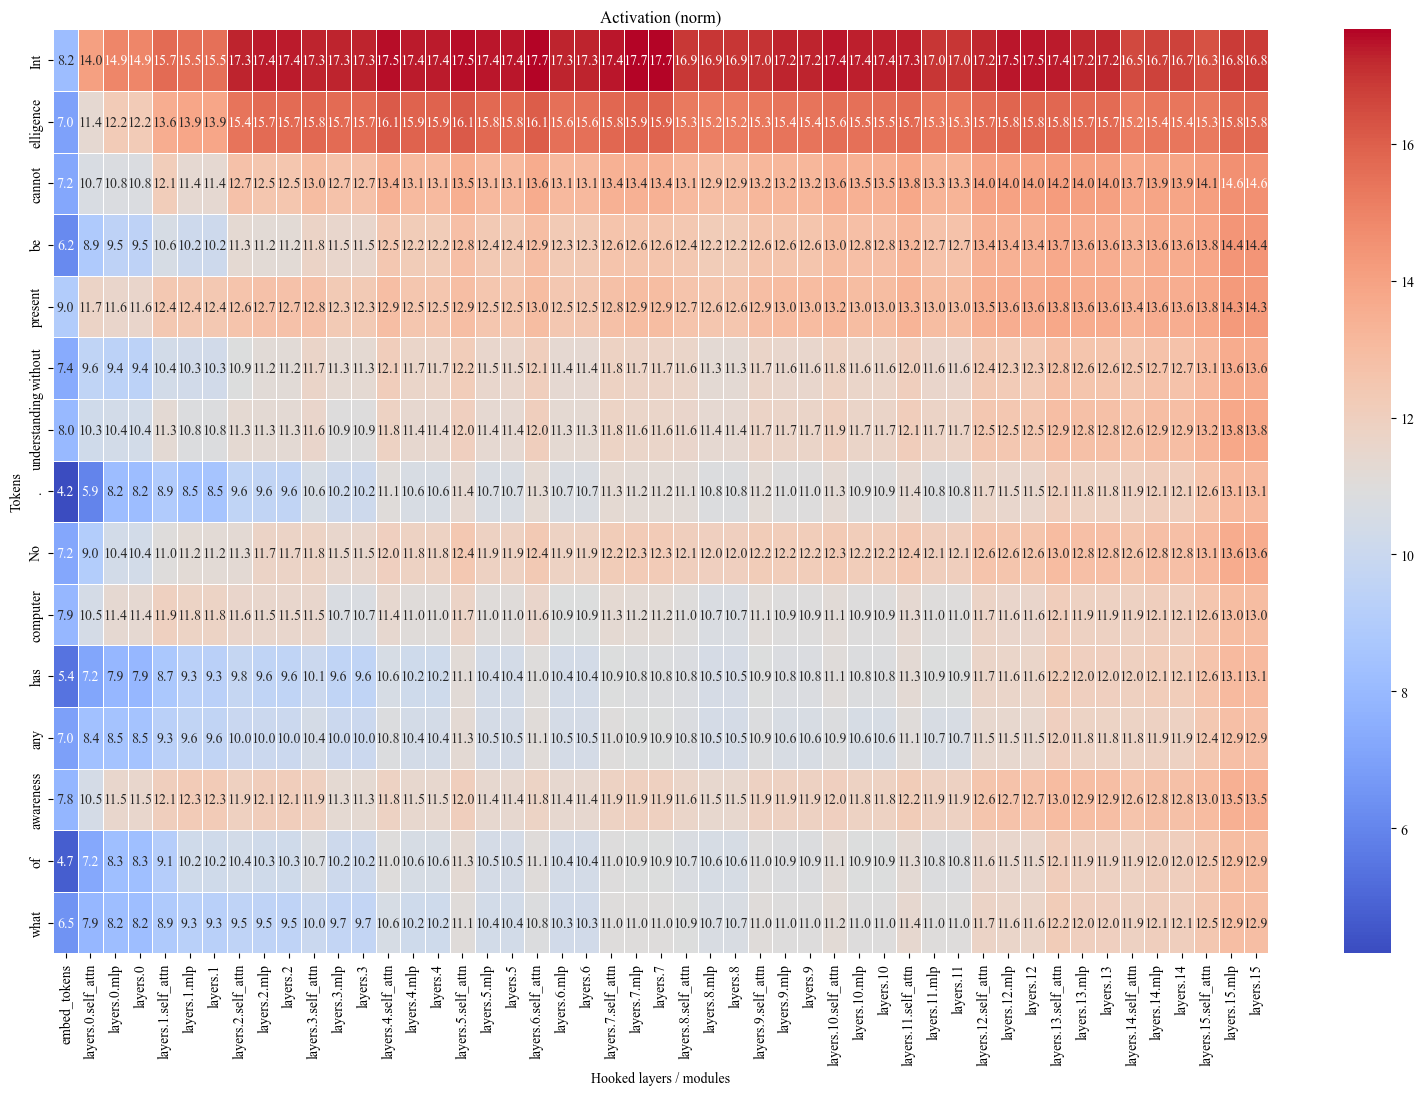

In [17]:
activation_lens.plot_activation_lens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    #save_fig_path='Outputs/FP/act_norm_deep3b_fp32_math.png',
    save_fig_path=None,
)

Shape of diff_vals: (15, 49)
Shape of mask: (15, 49)


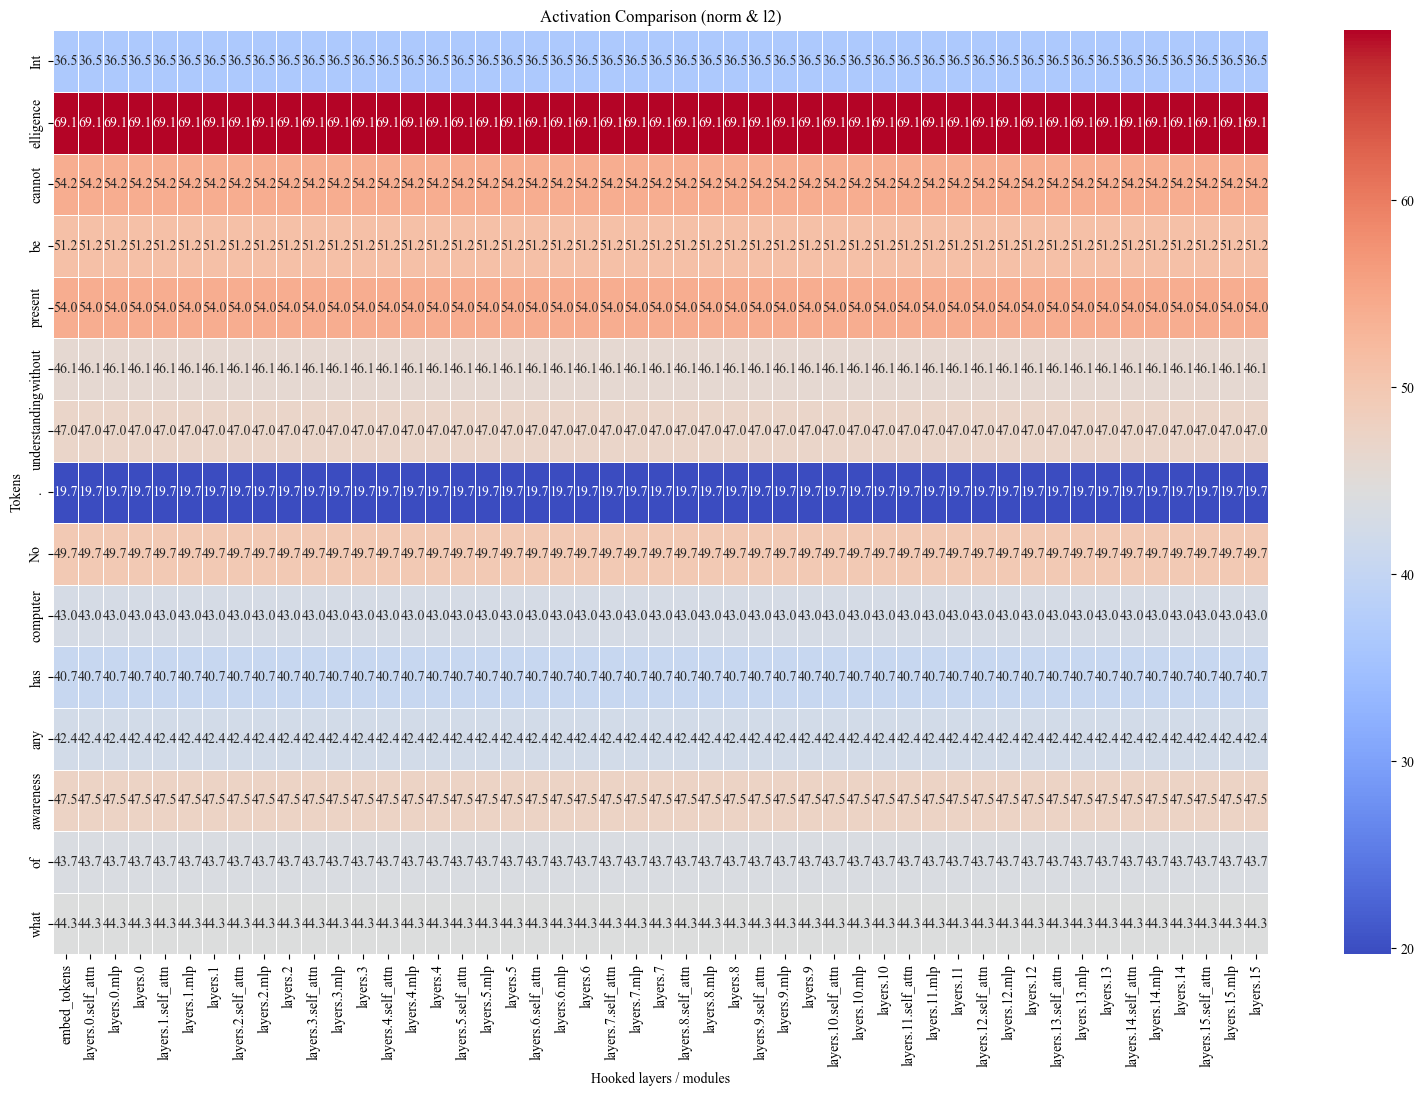

In [18]:
activation_lens.plot_comparing_act_lens(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    input_ids=PARAMS.get('prompt'),
    start_ix=0, end_ix=15,
    metric='norm',
    metric_name='l2',
    #save_fig_path='Outputs/PTQ/act_norm-l2_deep3b_fp32_158bit_sym-math.png',
    save_fig_path=None,
)

# Dictionary Learning: SAE

In [19]:
dictionary_learning.plot_sae_tokens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=False,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [20]:
dictionary_learning.plot_sae_tokens(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=PARAMS.get('prompt'),
    multi_tokens=True,
    do_log=False,
    target_layers=[5],
    vis_projection=None,
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [21]:
dictionary_learning.plot_sae_heatmap(
    model=olmo_fp16,
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    fig_path=None
)


Running SAE on layer 5


In [22]:
dictionary_learning.plot_sae_heatmap(
    model=olmo1b_bitnet_fp32,
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    do_log=False,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    log_path=None,
    log_name=None,
    #fig_path='Outputs/FP/sae5_deep3b_fp32_math.png',
)


Running SAE on layer 5


In [23]:
dictionary_learning.plot_comparing_heatmap(
    models=(olmo_fp16, olmo1b_bitnet_fp32),
    tokenizer=olmo_tokenizer,
    inputs=Texts.T1.value,
    top_k=5,
    tokens_per_row=30,
    target_layers=[5],
    #fig_path='Outputs/PTQ/sae5_deep3b_fp32_158bit_sym-math.png',
    fig_path=None
)


Comparing SAE on layer 5
